# GSE161529 Oncogene Analysis

## Table of Contents
1. [Introduction](#introduction)
2. [Imports](#imports)
3. [Path for Assets](#path-for-assets)
4. [Data Loading](#data-loading)
5. [Data Preparation](#data-preparation)
6. [Visualisation of Expression and DE Genes](#visualisation-of-expression-and-de-genes)
7. [Pathway and Network Analysis](#pathway-and-network-analysis)

## Introduction

In this notebook, we will analyze the GSE161529 dataset, focusing on the oncogenes involved. We will visualize the interactions between these genes and their expression changes in tumor samples compared to normal tissues.

## Imports

In [ ]:
# Necessary imports for the notebook. Please ensure these libraries are installed in your Python environment, 
# if not then please install them using the requirements.txt file.
import scanpy as sc
import pandas as pd
from gtfparse import read_gtf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind
from scipy.stats import spearmanr
from scipy.stats import mannwhitneyu
import networkx as nx
from matplotlib import cm
import matplotlib.colors as mcolors

## Path for Assets

In [2]:
# This is the relative path of the assets directory, if the assets are in another location please change the path accordingly.
assets = "../assets"

## Data Loading

In [3]:
df_val_clean = pd.read_csv(f"{assets}/GSE161529/GSE161529_predictions.csv", index_col=0)
df_val_clean

,Unnamed: 0,sample,sample_id,nCount_RNA,percent.mito,pct_counts_ribo,oxphos_score,apoptosis_score,S_score,G2M_score,phase,cnv_reference,cnv_score,proto_oncogenescore,tumor_prob_mito,tumor_pred_mito,tumor_pred_label_mito
0,AAACCTGAGACTAGGC-1,GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total,3587.0,0.0,34.011710,0.625094,-0.107095,-0.267442,-0.172494,G1,tumor,0.015120,0.1,0.997642,1,Predicted Tumor
1,AAACCTGAGGACAGAA-1,GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total,1003.0,0.0,41.375874,0.034769,-0.088353,-0.042636,-0.047786,G1,tumor,0.006566,0.1,0.692226,1,Predicted Tumor
2,AAACCTGAGGATGTAT-1,GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total,7536.0,0.0,34.262207,0.494331,1.516734,-0.428295,-0.325175,G1,tumor,0.036739,1.4,0.969477,1,Predicted Tumor
3,AAACCTGCAAGAGGCT-1,GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total,10366.0,0.0,27.532318,1.197279,-0.373494,-0.451550,-0.168998,G1,tumor,0.057310,0.7,0.996261,1,Predicted Tumor
4,AAACCTGGTAGCTTGT-1,GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total,1628.0,0.0,29.545454,-0.016629,0.073628,-0.058140,-0.006993,G1,tumor,0.008319,0.7,0.996349,1,Predicted Tumor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428019,TTTGTCACATCGATTG-1,GSM4909321_mER-MH0068-LN,GSM4909321_mER-MH0068-LN,2292.0,0.0,25.349040,0.458050,-0.069612,-0.081395,-0.070513,G1,tumor,0.034002,0.5,0.997924,1,Predicted Tumor
428020,TTTGTCACATGTTCCC-1,GSM4909321_mER-MH0068-LN,GSM4909321_mER-MH0068-LN,2283.0,0.0,22.864650,0.801209,-0.277108,-0.125969,-0.037296,G1,tumor,0.029496,0.2,0.999883,1,Predicted Tumor
428021,TTTGTCAGTAATTGGA-1,GSM4909321_mER-MH0068-LN,GSM4909321_mER-MH0068-LN,604.0,0.0,36.754967,0.705971,-0.040161,-0.029070,-0.004079,G1,tumor,0.017931,0.0,0.805429,1,Predicted Tumor
428022,TTTGTCATCATGTCCC-1,GSM4909321_mER-MH0068-LN,GSM4909321_mER-MH0068-LN,1954.0,0.0,31.064484,0.484505,-0.161981,-0.139535,-0.045455,G1,tumor,0.027329,0.2,0.999633,1,Predicted Tumor


In [4]:
# Load adata
adata = sc.read(f"{assets}/GSE161529/GSE161529_adata.h5ad")

a:\Projects\Capstone Local-GIt\ghost-cell-busters\venv\Lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [5]:
# Print some gene names to inspect
adata.var_names[:10]

Index(['ENSG00000243485', 'ENSG00000237613', 'ENSG00000186092',
       'ENSG00000238009', 'ENSG00000239945', 'ENSG00000239906',
       'ENSG00000241599', 'ENSG00000236601', 'ENSG00000284733',
       'ENSG00000235146'],
      dtype='object')

In [6]:
adata.var

""
ENSG00000243485
ENSG00000237613
ENSG00000186092
ENSG00000238009
ENSG00000239945
...
ENSG00000277856
ENSG00000275063
ENSG00000271254
ENSG00000277475


In [7]:
for name in adata.obs_names[:10]:
    print(name)

AAACCTGAGACTAGGC-1
AAACCTGAGGACAGAA-1
AAACCTGAGGATGTAT-1
AAACCTGCAAGAGGCT-1
AAACCTGGTAGCTTGT-1
AAACCTGTCAAGGTAA-1
AAACGGGAGAGGTAGA-1
AAACGGGAGATGGCGT-1
AAACGGGAGATTACCC-1
AAACGGGAGCACCGCT-1


## Data Preparation

In [8]:
# Extract the base cell ID before the first two dashes (e.g., "AAACCTGAGACTAGGC-1")
# Split on dash and rejoin first two parts
adata.obs["cell_id_short"] = adata.obs_names.str.split("-").str[:2].str.join("-")
adata.obs["cell_id_short"].head()

AAACCTGAGACTAGGC-1    AAACCTGAGACTAGGC-1
AAACCTGAGGACAGAA-1    AAACCTGAGGACAGAA-1
AAACCTGAGGATGTAT-1    AAACCTGAGGATGTAT-1
AAACCTGCAAGAGGCT-1    AAACCTGCAAGAGGCT-1
AAACCTGGTAGCTTGT-1    AAACCTGGTAGCTTGT-1
Name: cell_id_short, dtype: object

In [9]:
# Set cell barcodes as index
df_val_clean = df_val_clean.set_index("Unnamed: 0")
df_val_clean.index[:5].tolist()

['AAACCTGAGACTAGGC-1',
 'AAACCTGAGGACAGAA-1',
 'AAACCTGAGGATGTAT-1',
 'AAACCTGCAAGAGGCT-1',
 'AAACCTGGTAGCTTGT-1']

In [10]:
# Extract short cell ID (cell-barcode-1) from long index
df_val_clean["cell_id_short"] = df_val_clean.index.str.split("-").str[:2].str.join("-")

# Set as index
df_val_clean = df_val_clean.set_index("cell_id_short")

# Confirm it's fixed
df_val_clean.index[:5].tolist()

['AAACCTGAGACTAGGC-1',
 'AAACCTGAGGACAGAA-1',
 'AAACCTGAGGATGTAT-1',
 'AAACCTGCAAGAGGCT-1',
 'AAACCTGGTAGCTTGT-1']

In [11]:
# Features to map
cols_to_map = [
    "tumor_pred_mito", "tumor_prob_mito", "tumor_pred_label_mito",
    "nCount_RNA", "pct_counts_ribo", "oxphos_score", "apoptosis_score",
    "S_score", "G2M_score", "proto_oncogenescore", "cnv_score"
]
# Drop duplicates (keep the first occurrence)
df_val_clean = df_val_clean[~df_val_clean.index.duplicated(keep="first")]


# Map from df_val_clean using the short index
for col in cols_to_map:
    adata.obs[col] = adata.obs["cell_id_short"].map(df_val_clean[col])

print("Successfully mapped predictions and features into adata.obs.")

Successfully mapped predictions and features into adata.obs.


In [12]:
# Deduplicate df_val_clean before mapping
df_val_clean = df_val_clean[~df_val_clean.index.duplicated(keep='first')]

# Now safely map
for col in cols_to_map:
    adata.obs[col] = adata.obs["cell_id_short"].map(df_val_clean[col])

print("Successfully mapped predictions and features into adata.obs (after deduplication).")
dup_count = df_val_clean.index.duplicated().sum()
print(f"Removed {dup_count} duplicate entries from df_val_clean.")

Successfully mapped predictions and features into adata.obs (after deduplication).
Removed 0 duplicate entries from df_val_clean.


In [13]:
# Make sure obs index matches short cell IDs
adata.obs["cell_id_short"] = adata.obs_names.str.split("-").str[:2].str.join("-")

# Features to map
cols_to_map = [
    "tumor_pred_mito", "tumor_prob_mito", "tumor_pred_label_mito",
    "nCount_RNA", "pct_counts_ribo", "oxphos_score", "apoptosis_score",
    "S_score", "G2M_score", "proto_oncogenescore", "cnv_score"
]

# Map from df_val_clean using the short index
for col in cols_to_map:
    adata.obs[col] = adata.obs["cell_id_short"].map(df_val_clean[col])

print("Successfully mapped predictions and features into adata.obs.")

Successfully mapped predictions and features into adata.obs.


In [14]:
# Restore full obs_names as the index
adata.obs.index = adata.obs_names
# Make a short ID column to match df_val_clean
adata.obs["cell_id_short"] = adata.obs_names.str.split("-").str[:2].str.join("-")

# Map predictions from df_val_clean
adata.obs["tumor_pred_mito"] = adata.obs["cell_id_short"].map(df_val_clean["tumor_pred_mito"])
adata.obs["tumor_prob_mito"] = adata.obs["cell_id_short"].map(df_val_clean["tumor_prob_mito"])
adata.obs["tumor_pred_label_mito"] = adata.obs["cell_id_short"].map(df_val_clean["tumor_pred_label_mito"])

print("Successfully mapped predictions into adata.obs using cell_id_short")

Successfully mapped predictions into adata.obs using cell_id_short


In [15]:
dups = df_val_clean.index[df_val_clean.index.duplicated()]
print(f"Duplicate index entries in df_val_clean: {len(dups)}")
# Remove duplicates (keep first occurrence)
df_val_clean_dedup = df_val_clean[~df_val_clean.index.duplicated(keep="first")]

# Map predictions safely
adata.obs["tumor_pred_mito"] = adata.obs["cell_id_short"].map(df_val_clean_dedup["tumor_pred_mito"])
adata.obs["tumor_prob_mito"] = adata.obs["cell_id_short"].map(df_val_clean_dedup["tumor_prob_mito"])
adata.obs["tumor_pred_label_mito"] = adata.obs["cell_id_short"].map(df_val_clean_dedup["tumor_pred_label_mito"])

# Confirm success
print("Mapped predictions into adata.obs using deduplicated df_val_clean")
adata.obs[["cell_id_short", "tumor_pred_label_mito"]].dropna().head()

Duplicate index entries in df_val_clean: 0
Mapped predictions into adata.obs using deduplicated df_val_clean


,cell_id_short,tumor_pred_label_mito
AAACCTGAGACTAGGC-1,AAACCTGAGACTAGGC-1,Predicted Tumor
AAACCTGAGGACAGAA-1,AAACCTGAGGACAGAA-1,Predicted Tumor
AAACCTGAGGATGTAT-1,AAACCTGAGGATGTAT-1,Predicted Tumor
AAACCTGCAAGAGGCT-1,AAACCTGCAAGAGGCT-1,Predicted Tumor
AAACCTGGTAGCTTGT-1,AAACCTGGTAGCTTGT-1,Predicted Tumor


In [16]:
adata.obs["tumor_pred_label_mito"].value_counts()

tumor_pred_label_mito
Predicted Tumor     413839
Predicted Normal     14185
Name: count, dtype: int64

In [17]:
print("Tumor prediction counts:")
print(adata.obs["tumor_pred_label_mito"].value_counts())
features = [
    "nCount_RNA", "pct_counts_ribo", "oxphos_score", "apoptosis_score",
    "S_score", "G2M_score", "proto_oncogenescore", "cnv_score", "tumor_prob_mito"
]

summary_df = adata.obs.groupby("tumor_pred_label_mito")[features].mean().T.round(3)
summary_df

Tumor prediction counts:
tumor_pred_label_mito
Predicted Tumor     413839
Predicted Normal     14185
Name: count, dtype: int64


tumor_pred_label_mito,Predicted Normal,Predicted Tumor
nCount_RNA,834.924,5731.934
pct_counts_ribo,22.975,23.561
oxphos_score,0.100,0.750
apoptosis_score,-0.044,-0.105
S_score,-0.022,-0.257
G2M_score,-0.031,-0.213
proto_oncogenescore,0.049,0.501
cnv_score,0.016,0.034
tumor_prob_mito,0.258,0.970


In [18]:
# Parse GTF and build Ensembl-to-gene name map using gtfparse
gtf = read_gtf(f"{assets}/Gencode/gencode.v44.annotation.gtf").to_pandas()

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_name', 'level', 'tag', 'transcript_id', 'transcript_type', 'transcript_name', 'transcript_support_level', 'havana_transcript', 'exon_number', 'exon_id', 'hgnc_id', 'havana_gene', 'ont', 'protein_id', 'ccdsid', 'artif_dupl']


In [19]:
# Filter for gene entries only
gene_entries = gtf[gtf['feature'] == 'gene']

# Build gene_map dictionary from gene_id to gene_name
gene_map = {}
for _, row in gene_entries.iterrows():
    gene_id = row['gene_id'].split('.')[0]  # Remove version number
    gene_name = row['gene_name']
    if gene_id and gene_name:
        gene_map[gene_id] = gene_name

In [20]:
# Inspect current .var structure (optional but helpful)
print("Columns in adata.var:", adata.var_names.tolist())

# If 'ensembl_id' column is missing, extract it from the index
if "ensembl_id" not in adata.var.T.columns:
    adata.var["ensembl_id"] = adata.var.index.astype(str)

# Handle missing gene names
# Map Ensembl IDs (without version) to gene names using gene_map
ensembl_ids = adata.var["ensembl_id"].astype(str).str.split(".").str[0]
adata.var["gene_name"] = ensembl_ids.map(gene_map)
adata.var["gene_name"] = adata.var["gene_name"].fillna("Unknown")

# Combine gene_name and ensembl_id to make unique names
adata.var["gene_name_combined"] = adata.var["gene_name"] + "_" + adata.var["ensembl_id"]

# Step 4: Assign as var_names
adata.var_names = adata.var["gene_name_combined"]
adata.var_names_make_unique()

# Step 5: Confirm
print("Sample gene names:", adata.var_names[:10].tolist())

Columns in adata.var: ['ENSG00000243485', 'ENSG00000237613', 'ENSG00000186092', 'ENSG00000238009', 'ENSG00000239945', 'ENSG00000239906', 'ENSG00000241599', 'ENSG00000236601', 'ENSG00000284733', 'ENSG00000235146', 'ENSG00000284662', 'ENSG00000229905', 'ENSG00000237491', 'ENSG00000177757', 'ENSG00000225880', 'ENSG00000230368', 'ENSG00000272438', 'ENSG00000230699', 'ENSG00000241180', 'ENSG00000223764', 'ENSG00000187634', 'ENSG00000188976', 'ENSG00000187961', 'ENSG00000187583', 'ENSG00000187642', 'ENSG00000272512', 'ENSG00000188290', 'ENSG00000187608', 'ENSG00000224969', 'ENSG00000188157', 'ENSG00000273443', 'ENSG00000237330', 'ENSG00000131591', 'ENSG00000223823', 'ENSG00000272141', 'ENSG00000205231', 'ENSG00000162571', 'ENSG00000186891', 'ENSG00000186827', 'ENSG00000078808', 'ENSG00000176022', 'ENSG00000184163', 'ENSG00000260179', 'ENSG00000160087', 'ENSG00000230415', 'ENSG00000162572', 'ENSG00000131584', 'ENSG00000169972', 'ENSG00000127054', 'ENSG00000224051', 'ENSG00000169962', 'ENSG000

In [22]:
# Strip Ensembl suffix from gene names
adata.var_names = adata.var_names.str.split('_').str[0]
adata.var["gene_symbol"] = adata.var_names
adata.var_names_make_unique()

In [23]:
# Define genes of interest
oncogenes = [
    "MYC", "EGFR", "ERBB2", "CCND1", "BCL2", "PIK3CA", "AKT1", "KRAS", "NRAS", "HRAS",
    "MDM2", "FGFR1", "FGFR2", "MET", "CDK4", "CDK6", "SRC", "NOTCH1", "NTRK1", "NTRK2"
]
tumor_suppressors = [
    "TP53", "RB1", "BRCA1", "BRCA2", "CDKN2A", "CDKN1A", "PTEN", "SMAD4", "ATM", "ATR",
    "CHEK2", "NF1", "NF2", "STK11", "VHL", "WT1", "FOXO3", "BAX", "CASP8", "TSC2"
]
genes_of_interest = oncogenes + tumor_suppressors

# Match genes to adata.var_names (formatted like 'TP53_ENSG...')
genes_matched = [g for g in adata.var_names if g.split("_")[0] in genes_of_interest]

In [24]:
# Create DataFrame of expression values
X = adata[:, genes_matched].to_df()
X["tumor_label"] = adata.obs["tumor_pred_label_mito"].values

# Compute mean expression in tumor cells and sort genes
means = X.groupby("tumor_label").mean()
tumor_means = means.loc["Predicted Tumor"]
sorted_genes = tumor_means.sort_values(ascending=False).index.tolist()

# Top N genes
top_n = 25
top_genes = sorted_genes[:top_n]

## Visualisation of Expression and DE Genes

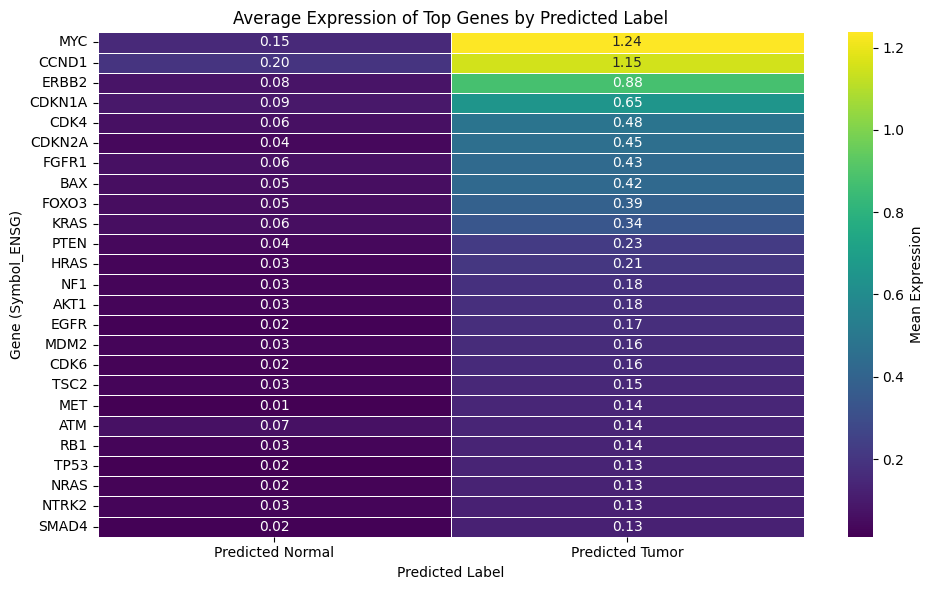

In [25]:
# Plot summary heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    means[top_genes].T,  # transpose for genes as rows
    cmap="viridis",
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"label": "Mean Expression"}
)
plt.title("Average Expression of Top Genes by Predicted Label")
plt.xlabel("Predicted Label")
plt.ylabel("Gene (Symbol_ENSG)")
plt.tight_layout()
plt.show()

In [26]:
# Group labels
labels = adata.obs["tumor_pred_label_mito"]

# Perform t-test and log2 fold change
results = []
for gene in genes_matched:
    tumor_vals = adata[labels == "Predicted Tumor", gene].X.toarray().flatten()
    normal_vals = adata[labels == "Predicted Normal", gene].X.toarray().flatten()
    
    # Avoid divide-by-zero or invalid mean
    if tumor_vals.size > 1 and normal_vals.size > 1:
        t_stat, p_val = ttest_ind(tumor_vals, normal_vals, equal_var=False)
        mean_diff = tumor_vals.mean() - normal_vals.mean()
        log2_fc = np.log2((tumor_vals.mean() + 1e-5) / (normal_vals.mean() + 1e-5))
        results.append((gene, p_val, log2_fc, mean_diff))

In [27]:
# Create DataFrame and filter
df_de = pd.DataFrame(results, columns=["gene", "p_value", "log2_fc", "mean_diff"])
df_de = df_de.sort_values("p_value")
df_de_sig = df_de[df_de["p_value"] < 0.05]

# 🧪 Show significant DE oncogenes
print("Differentially expressed oncogenes (p < 0.05):")
df_de_sig[["gene", "p_value", "log2_fc"]]

Differentially expressed oncogenes (p < 0.05):


,gene,p_value,log2_fc
0,NRAS,0.000000e+00,2.604683
20,PTEN,0.000000e+00,2.539006
22,KRAS,0.000000e+00,2.599416
23,CDK4,0.000000e+00,2.914858
24,MDM2,0.000000e+00,2.441233
26,RB1,0.000000e+00,2.274237
27,AKT1,0.000000e+00,2.726257
28,TSC2,0.000000e+00,2.301075
29,TP53,0.000000e+00,3.098227
30,NF1,0.000000e+00,2.701628


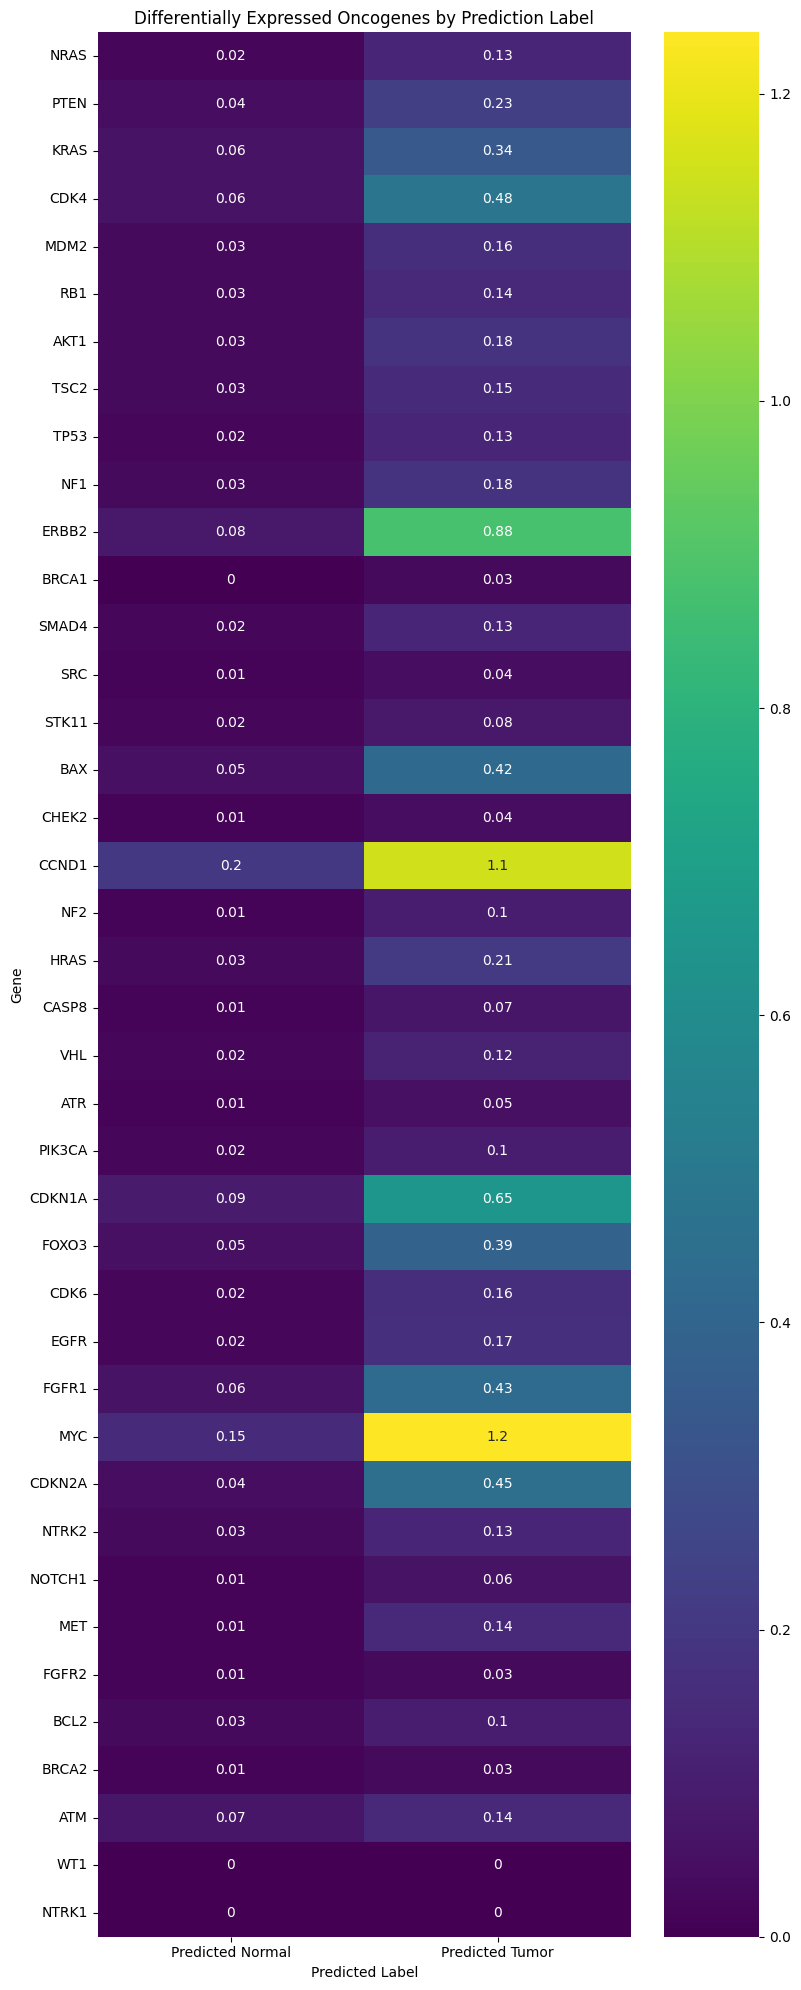

In [28]:
# Prepare matrix for heatmap
heatmap_data = []
for gene in df_de_sig["gene"]:
    tumor_mean = adata[labels == "Predicted Tumor", gene].X.mean()
    normal_mean = adata[labels == "Predicted Normal", gene].X.mean()
    heatmap_data.append([normal_mean, tumor_mean])

df_heatmap = pd.DataFrame(
    heatmap_data,
    index=df_de_sig["gene"],
    columns=["Predicted Normal", "Predicted Tumor"]
).round(2)

# Plot heatmap
plt.figure(figsize=(8, len(df_heatmap) * 0.5))
sns.heatmap(df_heatmap, annot=True, cmap="viridis")
plt.title("Differentially Expressed Oncogenes by Prediction Label")
plt.xlabel("Predicted Label")
plt.ylabel("Gene")
plt.tight_layout()
plt.show()

In [29]:
# Horizontal barplot of the top N differentially expressed oncogenes ranked by absolute log2 fold change
# Set N for top genes
top_n = 15

# Sort by absolute log2 fold change (descending) and take top N
top_genes_df = df_de_sig.copy()
top_genes_df["abs_log2_fc"] = top_genes_df["log2_fc"].abs()
top_genes_df = top_genes_df.sort_values("abs_log2_fc", ascending=False).head(top_n)

C:\Users\Haider-Rizvi\AppData\Local\Temp\ipykernel_26304\3221357646.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


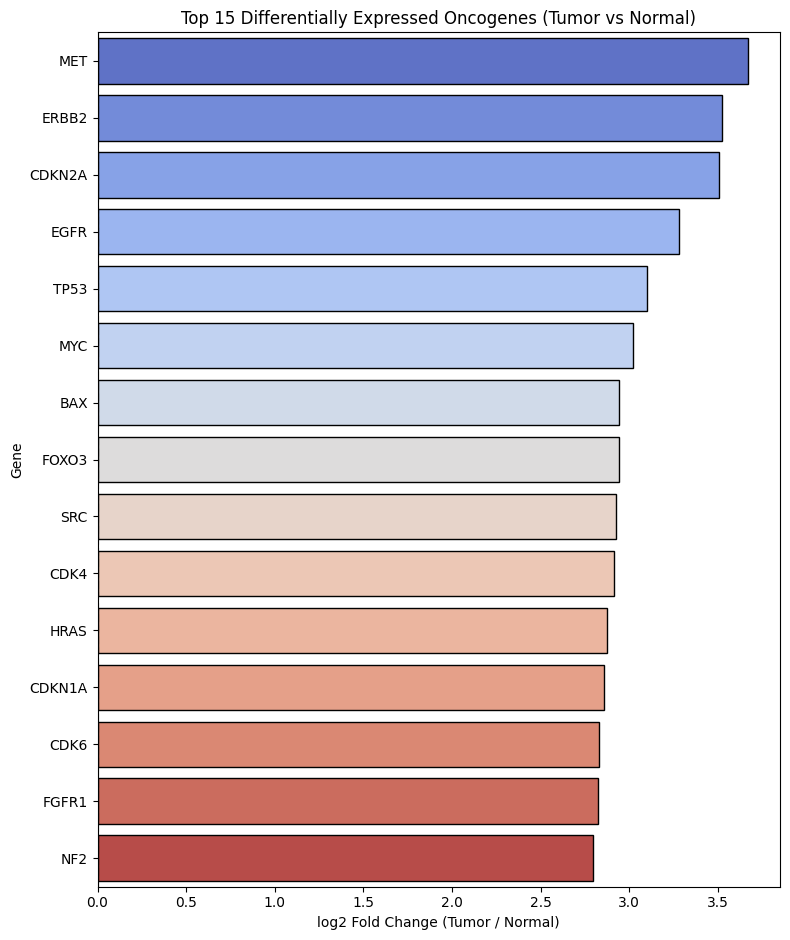

In [30]:
# Plot barplot
plt.figure(figsize=(8, 0.5 * top_n + 2))
sns.barplot(
    data=top_genes_df,
    y="gene",
    x="log2_fc",
    palette="coolwarm",
    edgecolor="black"
)
plt.axvline(0, color="black", linestyle="--")
plt.title(f"Top {top_n} Differentially Expressed Oncogenes (Tumor vs Normal)")
plt.xlabel("log2 Fold Change (Tumor / Normal)")
plt.ylabel("Gene")
plt.tight_layout()
plt.show()

... storing 'cell_id_short' as categorical
... storing 'gene_name' as categorical
... storing 'gene_symbol' as categorical


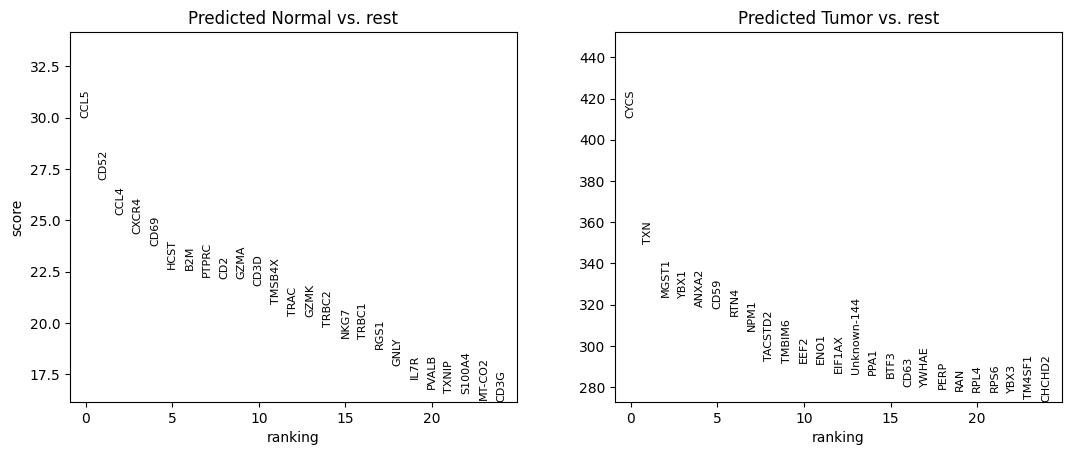

In [31]:
# Ensure categorical labels
adata.obs['tumor_pred_label_mito'] = adata.obs['tumor_pred_label_mito'].astype("category")

# Normalize and log-transform (safe now because raw is backed up)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Differential expression
sc.tl.rank_genes_groups(
    adata,
    groupby='tumor_pred_label_mito',
    method='t-test_overestim_var',
    key_added='de_tumor_vs_normal'
)

# Visualization
sc.pl.rank_genes_groups(
    adata,
    key='de_tumor_vs_normal',
    n_genes=25,
    sharey=False,
    figsize=(10, 5))

In [ ]:
df_de_sig.to_csv(f"{assets}/GSE161529/GSE161529_DE_oncogenes.csv", index=False)

In [32]:
# Extract the list of DE oncogenes from the CSV
matched_genes = df_de_sig['gene'][df_de_sig['gene'].isin(adata.var_names)].tolist()
print(f"Matched {len(matched_genes)} DE oncogenes:", matched_genes)

Matched 40 DE oncogenes: ['NRAS', 'PTEN', 'KRAS', 'CDK4', 'MDM2', 'RB1', 'AKT1', 'TSC2', 'TP53', 'NF1', 'ERBB2', 'BRCA1', 'SMAD4', 'SRC', 'STK11', 'BAX', 'CHEK2', 'CCND1', 'NF2', 'HRAS', 'CASP8', 'VHL', 'ATR', 'PIK3CA', 'CDKN1A', 'FOXO3', 'CDK6', 'EGFR', 'FGFR1', 'MYC', 'CDKN2A', 'NTRK2', 'NOTCH1', 'MET', 'FGFR2', 'BCL2', 'BRCA2', 'ATM', 'WT1', 'NTRK1']


In [33]:
adata.var_names[:10]

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'ENSG00000238009', 'ENSG00000239945',
       'ENSG00000239906', 'ENSG00000241599', 'ENSG00000236601', 'OR4F29',
       'ENSG00000235146'],
      dtype='object', name='gene_name_combined')

In [34]:
results = []

for gene in matched_genes:
    gene_expr = adata[:, gene].X.toarray().flatten()
    cnv_score = adata.obs["cnv_score"].values
    corr, pval = spearmanr(gene_expr, cnv_score)
    results.append({
        "gene": gene,
        "spearman_corr": round(corr, 3),
        "p_value": "{:.2e}".format(pval)
    })

In [35]:
# Convert to DataFrame and sort
df_corr = pd.DataFrame(results).sort_values("spearman_corr", ascending=False)

# Display
df_corr

,gene,spearman_corr,p_value
17,CCND1,0.375,0.00e+00
3,CDK4,0.373,0.00e+00
2,KRAS,0.319,0.00e+00
19,HRAS,0.310,0.00e+00
25,FOXO3,0.309,0.00e+00
15,BAX,0.308,0.00e+00
10,ERBB2,0.299,0.00e+00
29,MYC,0.299,0.00e+00
6,AKT1,0.281,0.00e+00
1,PTEN,0.280,0.00e+00


C:\Users\Haider-Rizvi\AppData\Local\Temp\ipykernel_26304\3687748354.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_corr, x="spearman_corr", y="gene", palette="viridis")


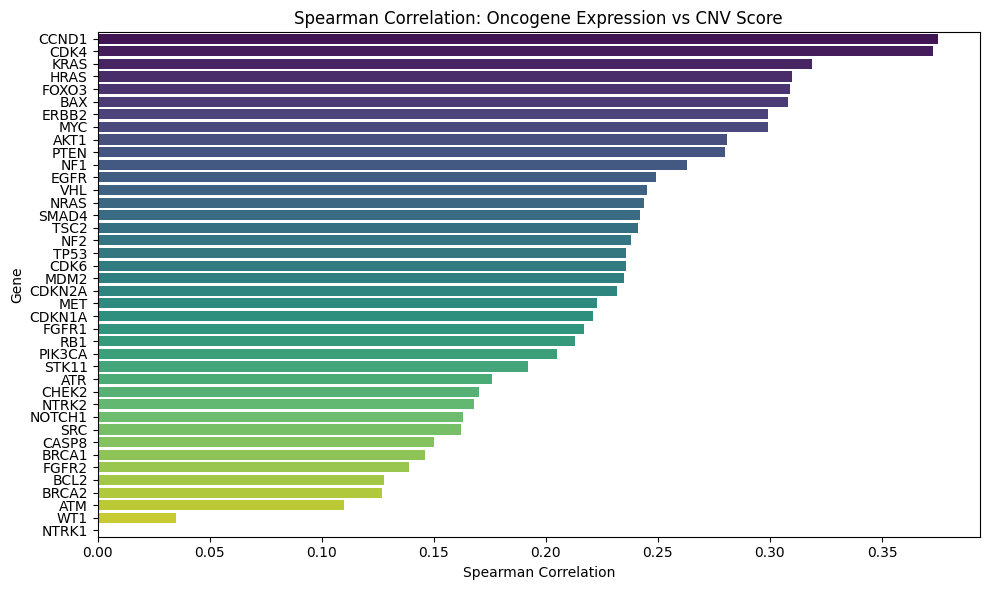

In [36]:
# Spearman Correlation: Oncogene Expression vs CNV Score
plt.figure(figsize=(10, 6))
sns.barplot(data=df_corr, x="spearman_corr", y="gene", palette="viridis")
plt.title("Spearman Correlation: Oncogene Expression vs CNV Score")
plt.xlabel("Spearman Correlation")
plt.ylabel("Gene")
plt.tight_layout()
plt.show()

In [37]:
# Genes of interest with therapeutic potential
pathway_genes = ["CCND1", "ERBB2", "HRAS", "CDK4", "AKT1", "MYC", "KRAS", "EGFR"]

In [38]:
# Extract expression values
X = adata[:, pathway_genes].to_df()
X["label"] = adata.obs["tumor_pred_label_mito"].values

# Compute mean expression per group
means = X.groupby("label").mean()

# Sort genes by tumor - normal difference
diff = means.loc["Predicted Tumor"] - means.loc["Predicted Normal"]
sorted_genes = diff.sort_values(ascending=False).index.tolist()

C:\Users\Haider-Rizvi\AppData\Local\Temp\ipykernel_26304\2728849255.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = X.groupby("label").mean()


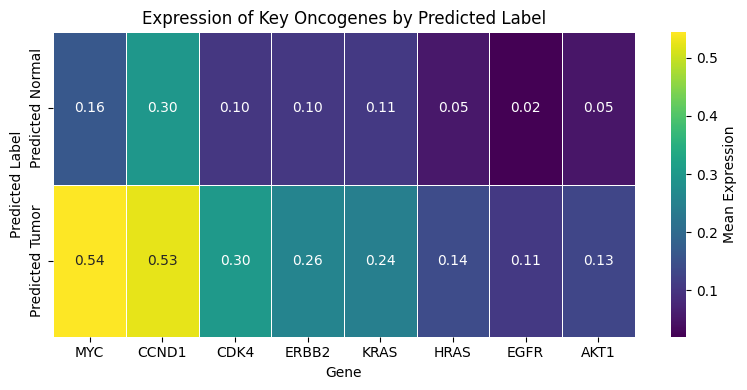

In [39]:
# Plot annotated heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(
    means[sorted_genes], 
    cmap="viridis", 
    annot=True, 
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"label": "Mean Expression"}
)
plt.title("Expression of Key Oncogenes by Predicted Label")
plt.xlabel("Gene")
plt.ylabel("Predicted Label")
plt.tight_layout()
plt.show()

In [40]:
# Compute log2 fold-change
eps = 1e-6
log2fc = np.log2((means.loc["Predicted Tumor"] + eps) / (means.loc["Predicted Normal"] + eps))

# Sort genes by log2 fold-change
sorted_genes = log2fc.sort_values(ascending=False).index.tolist()

# Rename genes to include log2FC in label
gene_labels = [f"{gene} (log2FC={log2fc[gene]:.2f})" for gene in sorted_genes]

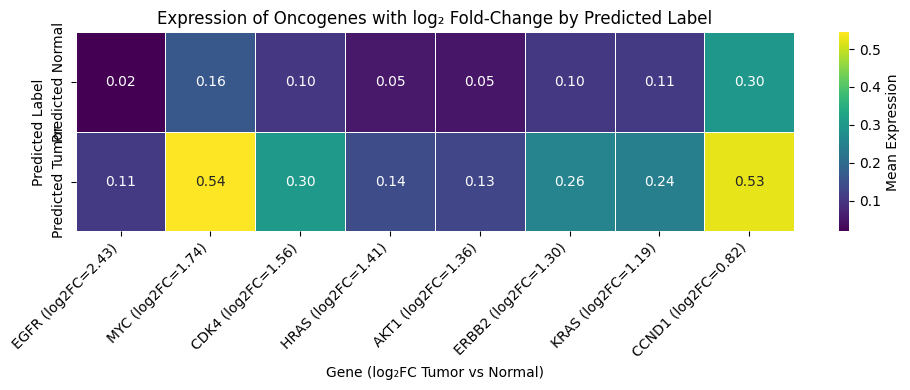

In [41]:
# Re-plot with annotation and renamed genes
plt.figure(figsize=(10, 4))
sns.heatmap(
    means[sorted_genes], 
    cmap="viridis", 
    annot=True, 
    fmt=".2f", 
    linewidths=0.5,
    cbar_kws={"label": "Mean Expression"}
)
plt.xticks(ticks=np.arange(len(gene_labels)) + 0.5, labels=gene_labels, rotation=45, ha='right')
plt.title("Expression of Oncogenes with log₂ Fold-Change by Predicted Label")
plt.xlabel("Gene (log₂FC Tumor vs Normal)")
plt.ylabel("Predicted Label")
plt.tight_layout()
plt.show()

In [42]:
# Compute neighbors (after PCA)
sc.pp.pca(adata)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)

# Compute UMAP embedding
sc.tl.umap(adata)

a:\Projects\Capstone Local-GIt\ghost-cell-busters\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


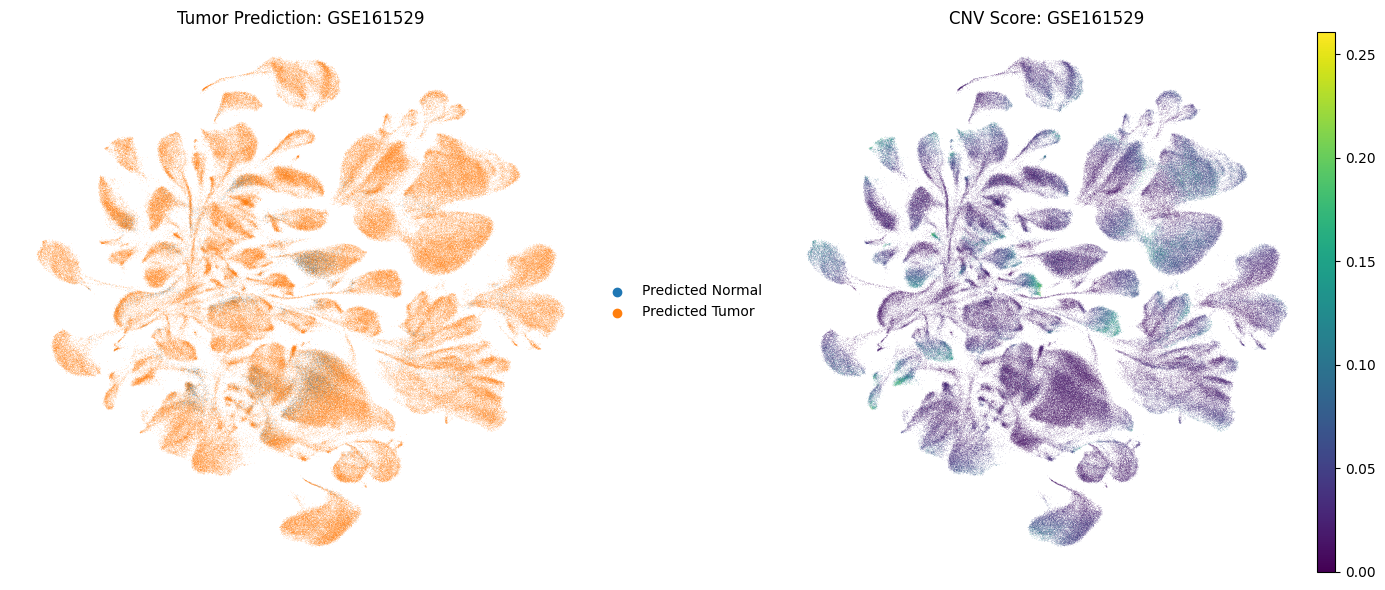

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# UMAP: Tumor predictions
sc.pl.umap(
    adata,
    color="tumor_pred_label_mito",
    title="Tumor Prediction: GSE161529",
    ax=axs[0],
    show=False,
    frameon=False
)

# UMAP: CNV score
sc.pl.umap(
    adata,
    color="cnv_score",
    cmap="viridis",
    title="CNV Score: GSE161529",
    ax=axs[1],
    show=False,
    frameon=False
)

plt.tight_layout()
plt.show()

a:\Projects\Capstone Local-GIt\ghost-cell-busters\venv\Lib\site-packages\legacy_api_wrap\__init__.py:82: FutureWarning: `scale` is deprecated, use `density_norm` instead
  return fn(*args_all, **kw)


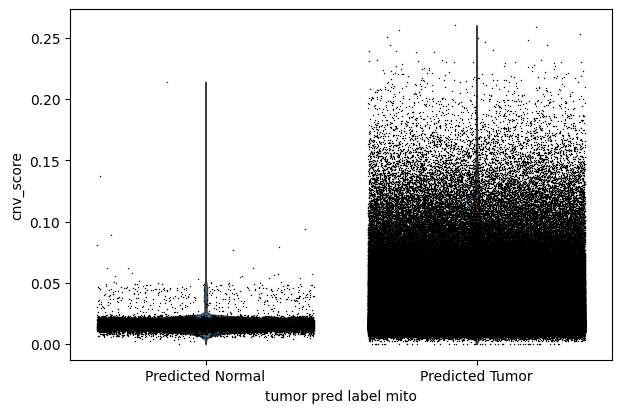

In [44]:
# This violin plot provides strong evidence that Predicted Tumor cells in GSE180286 tend to have higher CNV scores 
# than Predicted Normal cells.
sc.pl.violin(
    adata,
    keys="cnv_score",
    groupby="tumor_pred_label_mito",
    jitter=0.4,
    stripplot=True,
    scale="width",
    show=True
)

In [45]:
# The result supports the biological validity of our tumor prediction model.
# High CNV scores in tumor-labeled cells are consistent with genomic instability — a hallmark of many cancers.
# This makes CNV score an orthogonal validation of our ML classifier’s predictions.
group1 = adata.obs.loc[adata.obs["tumor_pred_label_mito"] == "Predicted Normal", "cnv_score"]
group2 = adata.obs.loc[adata.obs["tumor_pred_label_mito"] == "Predicted Tumor", "cnv_score"]

u_stat, p_val = mannwhitneyu(group1, group2, alternative="two-sided")
print(f"U-statistic: {u_stat:.2e}")
print(f"P-value: {p_val:.2e}")

U-statistic: 1.38e+09
P-value: 0.00e+00


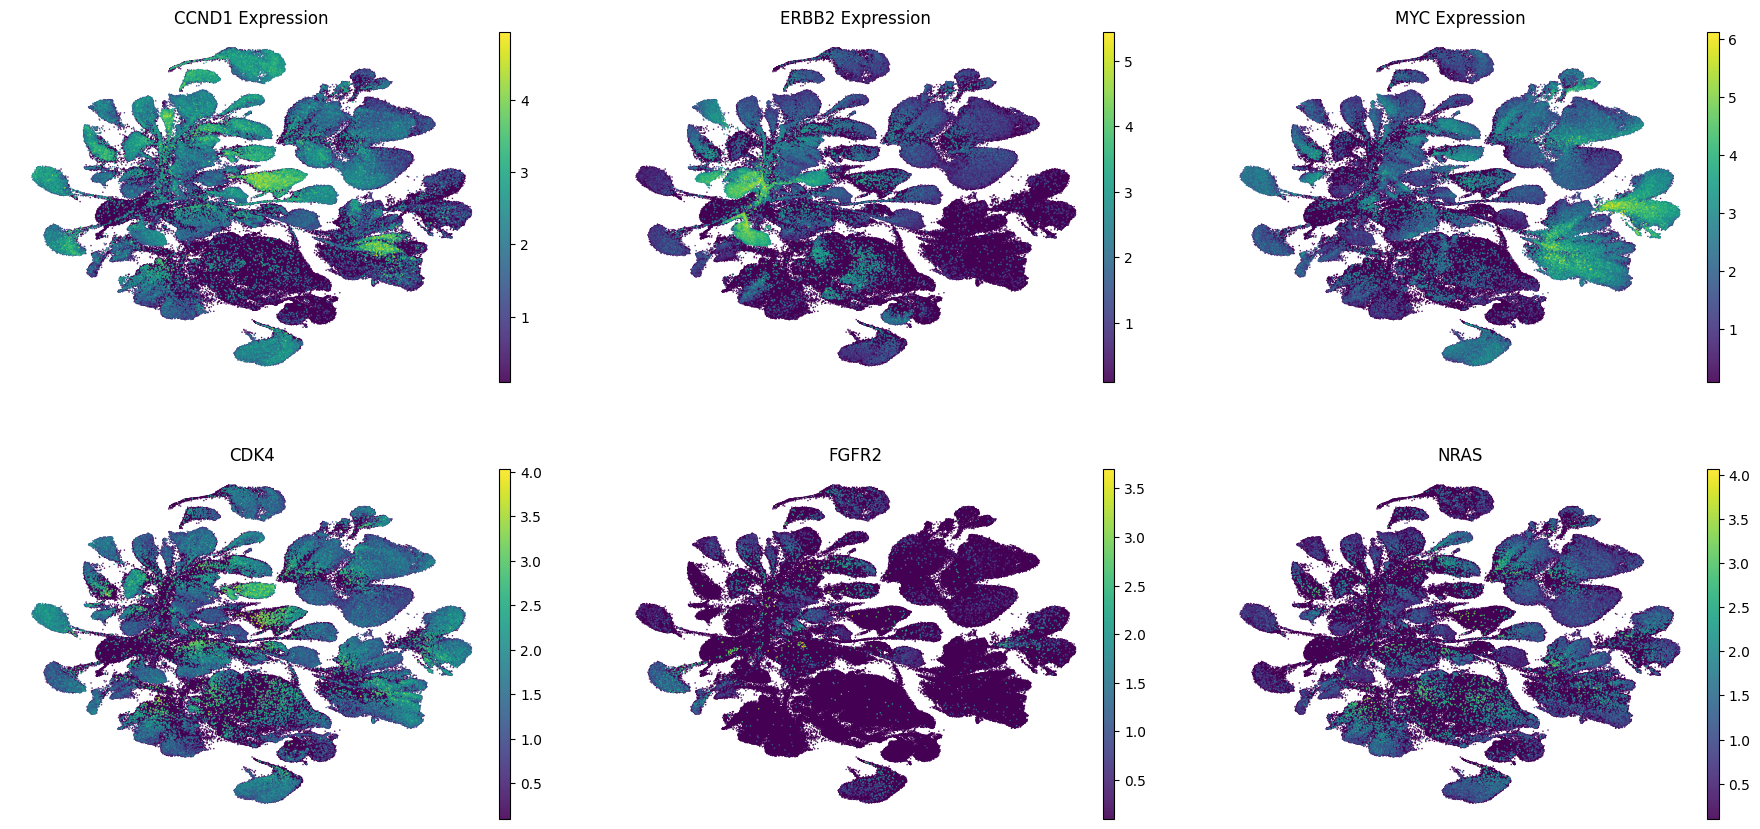

In [46]:
sc.pl.umap(
    adata, 
    color=["CCND1", "ERBB2", "MYC","CDK4","FGFR2","NRAS"],
    cmap="viridis",
    vmin=0.1, vmax=None,
    alpha=0.9,
    size=5,
    ncols=3,
    frameon=False,
    title=["CCND1 Expression", "ERBB2 Expression", "MYC Expression"]
)

In [47]:
# Statistical testing to compare gene expression between predicted tumor and normal cells across our oncogenes of interest 
# in the GSE161529 dataset.

# Loop through each gene and compare predicted tumor vs normal
for gene in genes_of_interest:
    if gene not in adata.var_names:
        print(f"Gene {gene} not found in adata3.var_names")
        continue
    
    expr = adata[:, gene].X.toarray().flatten() if hasattr(adata[:, gene].X, "toarray") else adata[:, gene].X
    labels = adata.obs["tumor_pred_label_mito"]

    tumor_expr = expr[labels == "Predicted Tumor"]
    normal_expr = expr[labels == "Predicted Normal"]

    stat, p = mannwhitneyu(tumor_expr, normal_expr, alternative="two-sided")
    
    results.append({
        "Gene": gene,
        "Tumor_Mean": np.mean(tumor_expr),
        "Normal_Mean": np.mean(normal_expr),
        "U_statistic": stat,
        "p_value": p
    })

In [50]:
# Convert to DataFrame and clean p-values
df_stats = pd.DataFrame(results)

# Convert p_value column to numeric, handling any string values
df_stats["p_value"] = pd.to_numeric(df_stats["p_value"], errors='coerce')

# Remove any rows with NaN p-values (from failed conversions)
df_stats = df_stats.dropna(subset=['p_value'])

# Calculate Benjamini-Hochberg adjusted p-values
df_stats = df_stats.sort_values('p_value')
df_stats["adj_pval_bh"] = df_stats["p_value"] * len(df_stats) / df_stats["p_value"].rank(method="min")

# Cap adjusted p-values at 1.0
df_stats["adj_pval_bh"] = df_stats["adj_pval_bh"].clip(upper=1.0)

df_stats

,gene,spearman_corr,p_value,Gene,Tumor_Mean,Normal_Mean,U_statistic,adj_pval_bh
0,NRAS,0.244,0.000000e+00,NaN,NaN,NaN,NaN,0.000000e+00
28,FGFR1,0.217,0.000000e+00,NaN,NaN,NaN,NaN,0.000000e+00
29,MYC,0.299,0.000000e+00,NaN,NaN,NaN,NaN,0.000000e+00
30,CDKN2A,0.232,0.000000e+00,NaN,NaN,NaN,NaN,0.000000e+00
31,NTRK2,0.168,0.000000e+00,NaN,NaN,NaN,NaN,0.000000e+00
...,...,...,...,...,...,...,...,...
62,NaN,NaN,6.130957e-55,BRCA1,0.022977,0.009274,2.995934e+09,6.453639e-55
63,NaN,NaN,2.826435e-48,BRCA2,0.022336,0.010177,2.990160e+09,2.936556e-48
75,NaN,NaN,4.976913e-05,WT1,0.001608,0.000753,2.939408e+09,5.104527e-05
58,NaN,NaN,7.827815e-03,NTRK1,0.002239,0.001657,2.937714e+09,7.926901e-03


## Pathway and Network Analysis

In [51]:
# Key genes in PI3K–MAPK–EGFR axis
axis_genes = [
    "EGFR",      # receptor tyrosine kinase
    "PIK3CA",    # PI3K catalytic subunit
    "AKT1",      # PI3K effector
    "MTOR",      # downstream target of AKT
    "KRAS", "NRAS", "HRAS",  # MAPK upstream regulators
    "BRAF", "RAF1",          # MAPK kinase cascade
    "MAP2K1", "MAP2K2",      # MEK1/2
    "MAPK1", "MAPK3"         # ERK2/1
]
# Get matched genes (your var_names may be like 'EGFR_ENSG...')
matched_genes = [g for g in adata.var_names if g.split("_")[0] in axis_genes]
print(f"Matched genes: {matched_genes}")

Matched genes: ['MTOR', 'NRAS', 'RAF1', 'PIK3CA', 'EGFR', 'BRAF', 'HRAS', 'KRAS', 'AKT1', 'MAP2K1', 'MAPK3', 'MAP2K2', 'MAPK1']


In [52]:
# Create dataframe of expression for those genes
expr_df = adata[:, matched_genes].to_df()
expr_df["label"] = adata.obs["tumor_pred_label_mito"].values

# Group mean
group_means = expr_df.groupby("label").mean().T
print(group_means)

label               Predicted Normal  Predicted Tumor
gene_name_combined                                   
MTOR                        0.016457         0.041941
NRAS                        0.039459         0.101171
RAF1                        0.051870         0.128036
PIK3CA                      0.035617         0.078761
EGFR                        0.019896         0.106985
BRAF                        0.055349         0.121198
HRAS                        0.052907         0.140281
KRAS                        0.106993         0.244478
AKT1                        0.050228         0.129052
MAP2K1                      0.050229         0.133028
MAPK3                       0.048401         0.094391
MAP2K2                      0.085316         0.153031
MAPK1                       0.081312         0.168456


C:\Users\Haider-Rizvi\AppData\Local\Temp\ipykernel_26304\443166087.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_means = expr_df.groupby("label").mean().T


In [53]:
oncogenes = [
    "MYC", "EGFR", "ERBB2", "CCND1", "BCL2", "PIK3CA", "AKT1", "KRAS", "NRAS", "HRAS",
    "MDM2", "FGFR1", "FGFR2", "MET", "CDK4", "CDK6", "SRC", "NOTCH1", "NTRK2"
]
tumor_suppressors = [
    "TP53", "RB1", "BRCA1", "BRCA2", "CDKN2A", "CDKN1A", "PTEN", "SMAD4", "ATM", "ATR",
    "CHEK2", "NF1", "NF2", "STK11", "VHL", "WT1", "FOXO3", "BAX", "CASP8", "TSC2"
]
genes_of_interest = oncogenes + tumor_suppressors

labels = adata.obs["tumor_pred_label_mito"]
results = []

for gene in genes_of_interest:
    if gene in adata.var_names:
        tumor_vals = adata[labels == "Predicted Tumor", gene].X.toarray().flatten()
        normal_vals = adata[labels == "Predicted Normal", gene].X.toarray().flatten()
        
        if len(tumor_vals) > 1 and len(normal_vals) > 1:
            t_stat, p_val = ttest_ind(tumor_vals, normal_vals, equal_var=False)
            log2fc = np.log2((tumor_vals.mean() + 1e-6) / (normal_vals.mean() + 1e-6))
            results.append((gene, p_val, log2fc))

# Create DataFrame
gene_stat_df = pd.DataFrame(results, columns=["Gene", "pval", "log2FC"])

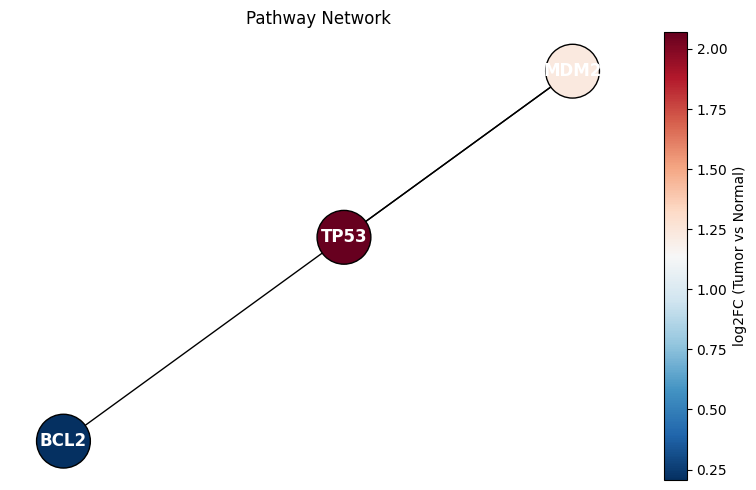

In [57]:
## MYC Signaling Axis with Tumor log2FC Overlay

def get_log2fc_dict(genes, gene_stat_df):
    # Ensure consistent case for matching
    genes = [g.upper() for g in genes]
    gene_stat_df["Gene"] = gene_stat_df["Gene"].str.upper()

    subset = gene_stat_df[gene_stat_df["Gene"].isin(genes)]
    if subset.empty:
        raise ValueError("None of the genes in the network were found in gene_stat_df.")
    return dict(zip(subset["Gene"], subset["log2FC"]))

def plot_log2fc_network(edges, log2fc_dict, title="Pathway Network"):
    G = nx.DiGraph()
    G.add_edges_from(edges)

    nodes = list(G.nodes())
    values = [log2fc_dict.get(node, 0) for node in nodes]

    vmin, vmax = min(values), max(values)
    cmap = cm.RdBu_r

    # Use TwoSlopeNorm only if values span both + and -
    if vmin < 0 < vmax:
        norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
    else:
        norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

    node_colors = [cmap(norm(val)) for val in values]

    pos = nx.spring_layout(G, seed=42)
    fig, ax = plt.subplots(figsize=(8, 5))  # Create explicit figure and axes
    
    nx.draw_networkx_edges(G, pos, arrows=True, edge_color="black", ax=ax)
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1500, edgecolors="black", ax=ax)
    nx.draw_networkx_labels(G, pos, font_color="white", font_weight="bold", ax=ax)

    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(values)  # Set the array to actual values
    cbar = plt.colorbar(sm, ax=ax)  # Specify the axes
    cbar.set_label("log2FC (Tumor vs Normal)")

    ax.set_title(title)  # Use ax.set_title instead of plt.title
    ax.axis("off")
    plt.tight_layout()
    plt.show()

tp53_edges = [
    ("TP53", "MDM2"),
    ("MDM2", "TP53"),
    ("TP53", "BCL2")
]
tp53_genes = list(set([g for edge in tp53_edges for g in edge]))
tp53_log2fc = get_log2fc_dict(tp53_genes, gene_stat_df)
plot_log2fc_network(tp53_edges, tp53_log2fc)

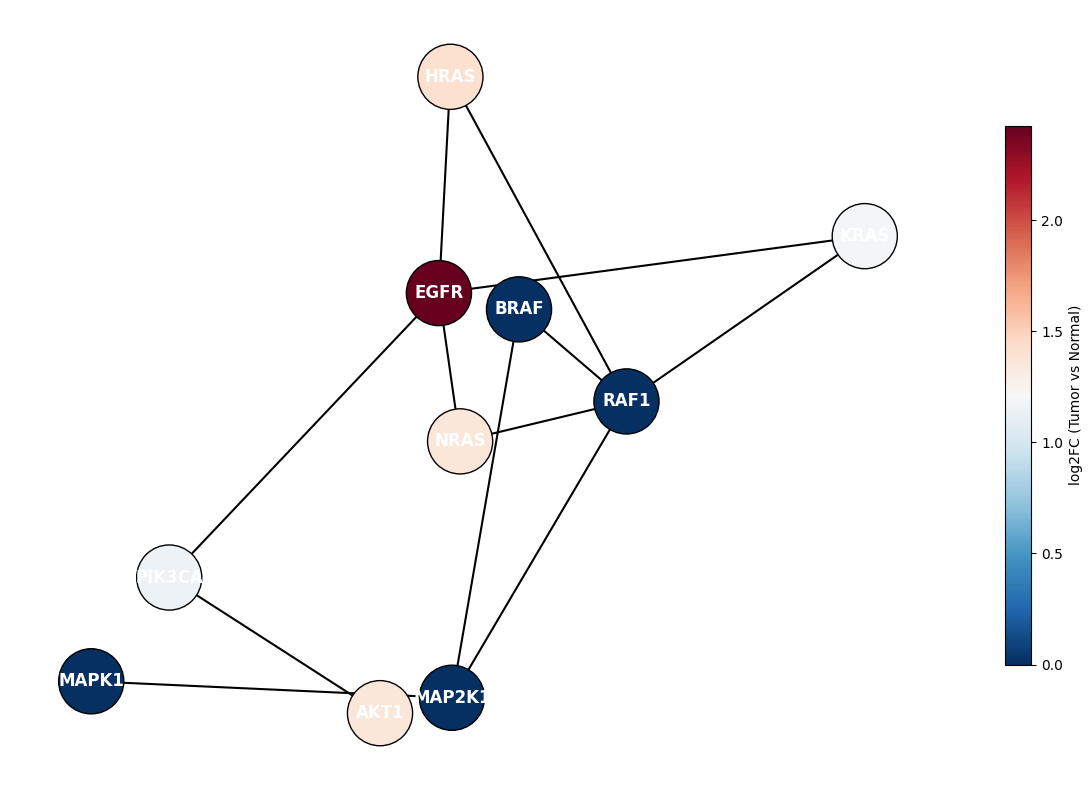

In [56]:
# Step 1: Define the expanded PI3K–MAPK–EGFR pathway edges
edges = [
    ("EGFR", "KRAS"),
    ("EGFR", "NRAS"),
    ("EGFR", "HRAS"),
    ("KRAS", "RAF1"),
    ("NRAS", "RAF1"),
    ("HRAS", "RAF1"),
    ("RAF1", "BRAF"),
    ("BRAF", "MAP2K1"),
    ("RAF1", "MAP2K1"),
    ("MAP2K1", "MAPK1"),
    ("EGFR", "PIK3CA"),
    ("PIK3CA", "AKT1")
]

# Step 2: Extract updated log2FC values
log2fc_dict = dict(zip(gene_stat_df["Gene"], gene_stat_df["log2FC"]))

# Step 3: Build the directed graph
G = nx.DiGraph()
G.add_edges_from(edges)

# Step 4: Color nodes by updated log2FC
nodes = list(G.nodes())
log2fc_values = [log2fc_dict.get(node, 0) for node in nodes]

vmin, vmax = min(log2fc_values), max(log2fc_values)
if vmin < 0 < vmax:
    norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
else:
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

cmap = cm.RdBu_r
node_colors = [cmap(norm(val)) for val in log2fc_values]

plt.figure(figsize=(12, 8))
ax = plt.gca()  # Get current axes

pos = nx.spring_layout(G, seed=42, k=0.7)
nx.draw_networkx_edges(G, pos, arrows=True, edge_color='black', width=1.5, ax=ax)
nx.draw_networkx_nodes(G, pos, node_size=2200, node_color=node_colors, edgecolors="black", ax=ax)
nx.draw_networkx_labels(G, pos, font_size=12, font_color='white', font_weight='bold', ax=ax)

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(log2fc_values)  # Important: assign the actual values here

plt.colorbar(sm, ax=ax, shrink=0.7, label="log2FC (Tumor vs Normal)")

plt.axis('off')
plt.tight_layout()
plt.show()

C:\Users\Haider-Rizvi\AppData\Local\Temp\ipykernel_26304\1405752028.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("RdBu_r")


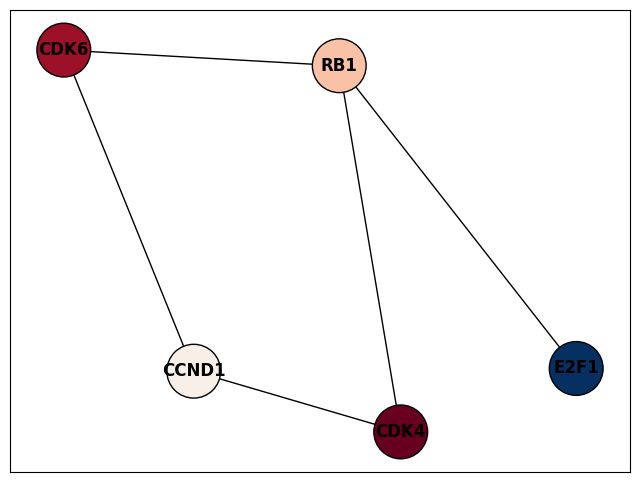

In [61]:
##CDK4–CDK6–CCND1 Axis with Tumor log₂FC Overlay 
# Define G1/S checkpoint genes
genes_of_interest = ["CCND1", "CDK4", "CDK6", "RB1", "E2F1"]

# Subset your updated gene_stat_df
subset_df = gene_stat_df[gene_stat_df["Gene"].isin(genes_of_interest)]

# Create log2FC dictionary
if subset_df.empty:
    raise ValueError("None of the genes in the G1/S axis were found in gene_stat_df.")
log2fc_dict = dict(zip(subset_df["Gene"], subset_df["log2FC"]))

# Define directed edges for the axis
edges = [
    ("CCND1", "CDK4"),
    ("CCND1", "CDK6"),
    ("CDK4", "RB1"),
    ("CDK6", "RB1"),
    ("RB1", "E2F1")
]

# Create the directed graph
G = nx.DiGraph()
G.add_edges_from(edges)

# Normalize node colors by log2FC
values = [log2fc_dict.get(node, 0) for node in G.nodes]
vmin, vmax = min(values), max(values)

# Use balanced normalization
if vmin < 0 < vmax:
    norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
else:
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

cmap = cm.get_cmap("RdBu_r")
node_colors = [cmap(norm(log2fc_dict.get(node, 0))) for node in G.nodes]

# Draw the network
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(8, 6))

nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle='-|>', edge_color="black")
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1500, edgecolors="black")


C:\Users\Haider-Rizvi\AppData\Local\Temp\ipykernel_26304\3055427549.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("RdBu_r")


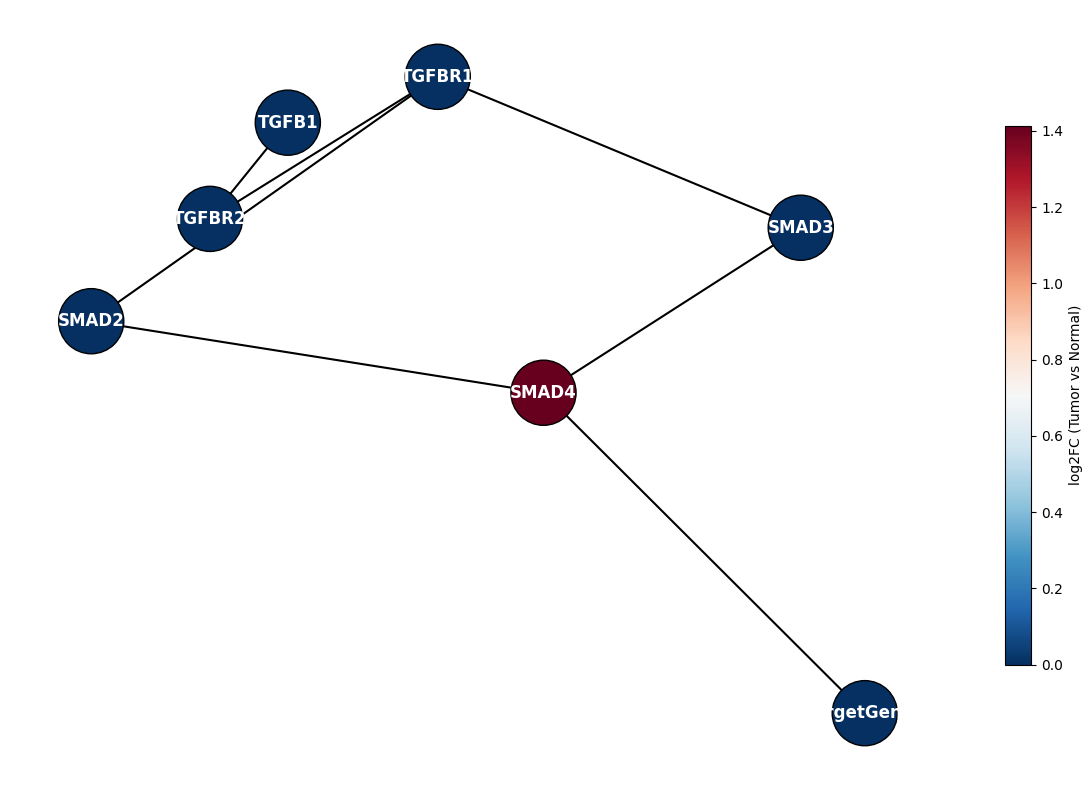

In [63]:
##TGF-β / SMAD Pathway Plotting Code
# Define pathway structure (simplified canonical TGF-β signaling)
edges = [
    ("TGFB1", "TGFBR2"),
    ("TGFBR2", "TGFBR1"),
    ("TGFBR1", "SMAD2"),
    ("TGFBR1", "SMAD3"),
    ("SMAD2", "SMAD4"),
    ("SMAD3", "SMAD4"),
    ("SMAD4", "TargetGenes")  # placeholder for downstream effects
]

# Extract genes from edges
tgfb_genes = list(set(g for edge in edges for g in edge if g != "TargetGenes"))

# Create log2FC dictionary from your DE dataframe
# Assumes gene_stat_df has "Gene" and "log2FC" columns
subset_df = gene_stat_df[gene_stat_df["Gene"].isin(tgfb_genes)]
log2fc_dict = dict(zip(subset_df["Gene"], subset_df["log2FC"]))

# Create the graph
G = nx.DiGraph()
G.add_edges_from(edges)

# Map log2FC to node colors
values = [log2fc_dict.get(node, 0) for node in G.nodes]
#vmin, vmax = min(values), max(values)
vmin, vmax = min(values), max(values)

if vmin < 0 < vmax:
    norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
else:
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)


cmap = cm.get_cmap("RdBu_r")
node_colors = [cmap(norm(log2fc_dict.get(node, 0))) for node in G.nodes]

# Add colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.figure(figsize=(12, 8))
ax = plt.gca()  # Get current axes

pos = nx.spring_layout(G, seed=42, k=0.7)
nx.draw_networkx_edges(G, pos, arrows=True, edge_color='black', width=1.5, ax=ax)
nx.draw_networkx_nodes(G, pos, node_size=2200, node_color=node_colors, edgecolors="black", ax=ax)
nx.draw_networkx_labels(G, pos, font_size=12, font_color='white', font_weight='bold', ax=ax)

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(log2fc_values)  # Important: assign the actual values here

plt.colorbar(sm, ax=ax, shrink=0.7, label="log2FC (Tumor vs Normal)")

plt.axis('off')
plt.tight_layout()
plt.show()

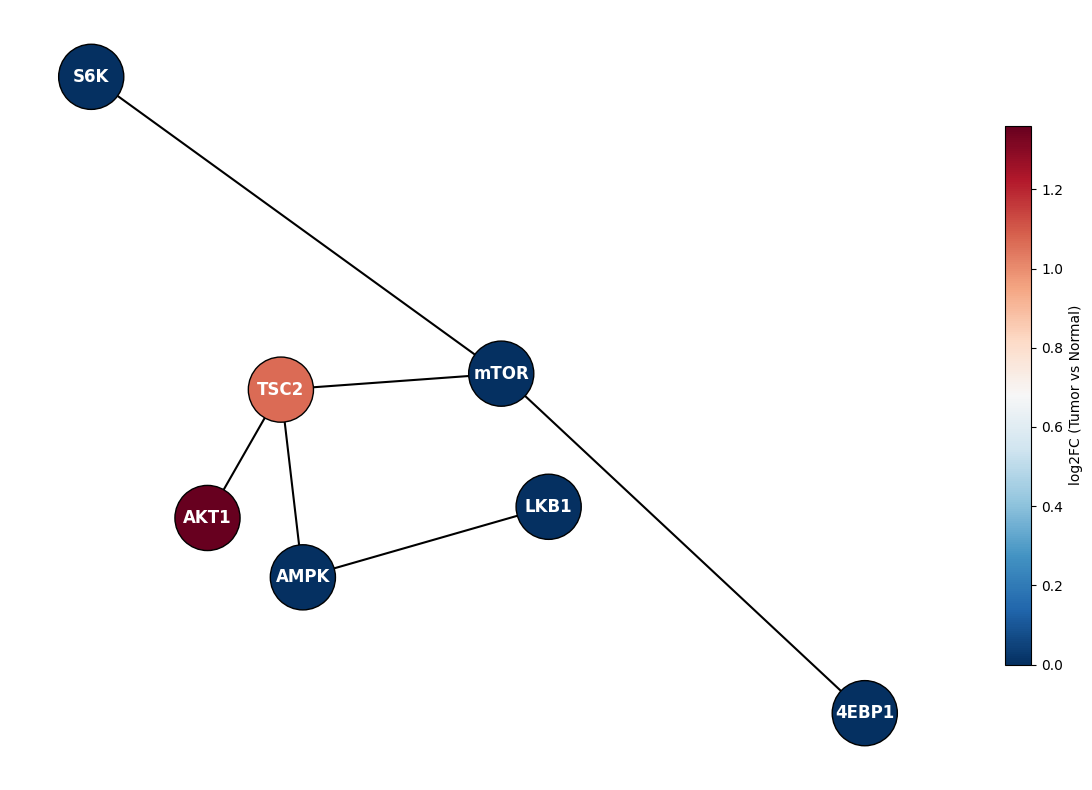

In [65]:
## Code for mTOR–AMPK Pathway Network
# Define the mTOR–AMPK pathway structure
edges = [
    ("LKB1", "AMPK"),
    ("AMPK", "TSC2"),
    ("TSC2", "mTOR"),
    ("AKT1", "TSC2"),
    ("mTOR", "S6K"),
    ("mTOR", "4EBP1")
]

# Genes in the network
genes = list(set([gene for edge in edges for gene in edge]))

# Extract log2FC values from your differential expression DataFrame
# Ensure 'Gene' and 'log2FC' columns are in gene_stat_df
subset = gene_stat_df[gene_stat_df["Gene"].isin(genes)]
if subset.empty:
    raise ValueError("None of the genes in the mTOR–AMPK network were found in gene_stat_df.")

log2fc_dict = dict(zip(subset["Gene"], subset["log2FC"]))

# Create the graph and color by log2FC
G = nx.DiGraph()
G.add_edges_from(edges)

values = [log2fc_dict.get(node, 0) for node in G.nodes]
vmin, vmax = min(values), max(values)

# Choose appropriate colormap
if vmin < 0 < vmax:
    norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
else:
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

cmap = cm.RdBu_r
node_colors = [cmap(norm(log2fc_dict.get(node, 0))) for node in G.nodes]

# Add colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.figure(figsize=(12, 8))
ax = plt.gca()  # Get current axes

pos = nx.spring_layout(G, seed=42, k=0.7)
nx.draw_networkx_edges(G, pos, arrows=True, edge_color='black', width=1.5, ax=ax)
nx.draw_networkx_nodes(G, pos, node_size=2200, node_color=node_colors, edgecolors="black", ax=ax)
nx.draw_networkx_labels(G, pos, font_size=12, font_color='white', font_weight='bold', ax=ax)

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(log2fc_values)  # Important: assign the actual values here

plt.colorbar(sm, ax=ax, shrink=0.7, label="log2FC (Tumor vs Normal)")

plt.axis('off')
plt.tight_layout()
plt.show()

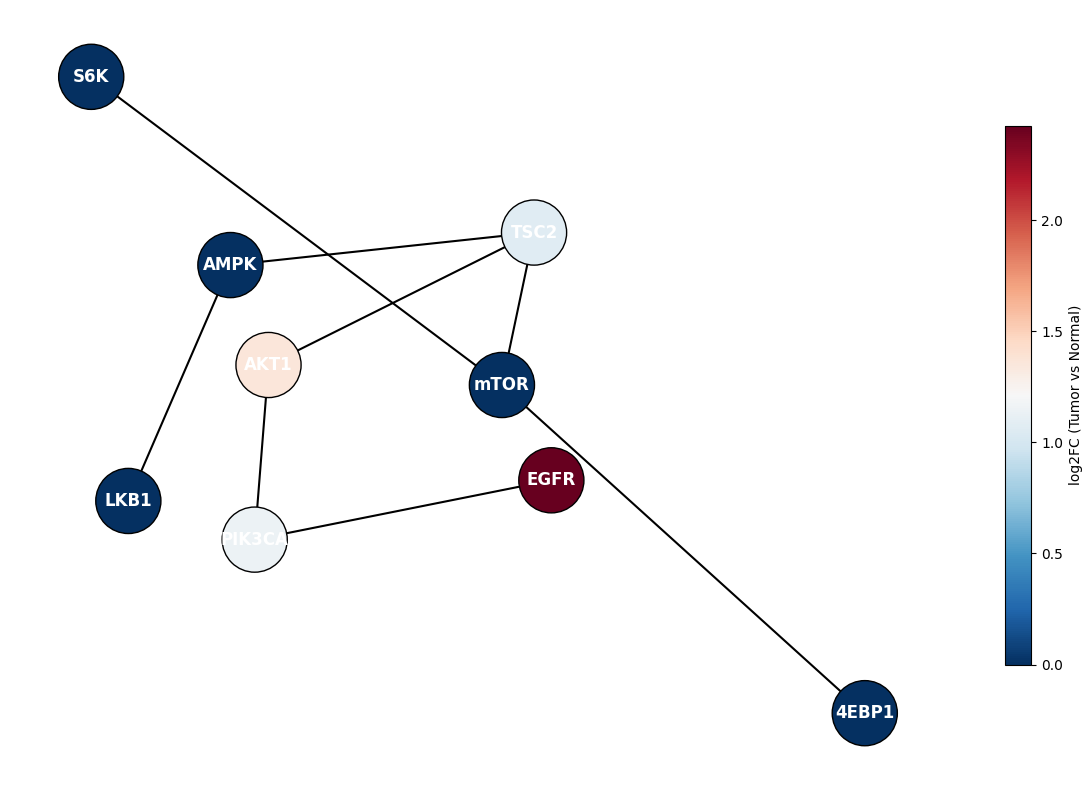

In [66]:
## PI3K–AKT–mTOR–AMPK Signaling Pathway Network
# Define nodes (pathway genes)
genes = ["EGFR", "PIK3CA", "AKT1", "TSC2", "mTOR", "S6K", "4EBP1", "LKB1", "AMPK"]

# Step 2: Define edges (signal flow)
edges = [
    ("EGFR", "PIK3CA"),
    ("PIK3CA", "AKT1"),
    ("AKT1", "TSC2"),
    ("TSC2", "mTOR"),
    ("mTOR", "S6K"),
    ("mTOR", "4EBP1"),
    ("LKB1", "AMPK"),
    ("AMPK", "TSC2")  # AMPK inhibits TSC2
]

# Extract log2FC from your gene_stat_df
log2fc_dict = dict(zip(gene_stat_df["Gene"], gene_stat_df["log2FC"]))
values = [log2fc_dict.get(gene, 0) for gene in genes]

# Normalize log2FC values for color mapping
vmin, vmax = 0, max(values)
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = cm.RdBu_r
node_colors = [cmap(norm(log2fc_dict.get(g, 0))) for g in genes]

# Build and plot the network
G = nx.DiGraph()
G.add_edges_from(edges)

# Add colorbar legend
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
plt.figure(figsize=(12, 8))
ax = plt.gca()  # Get current axes

pos = nx.spring_layout(G, seed=42, k=0.7)
nx.draw_networkx_edges(G, pos, arrows=True, edge_color='black', width=1.5, ax=ax)
nx.draw_networkx_nodes(G, pos, node_size=2200, node_color=node_colors, edgecolors="black", ax=ax)
nx.draw_networkx_labels(G, pos, font_size=12, font_color='white', font_weight='bold', ax=ax)

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(log2fc_values)  # Important: assign the actual values here

plt.colorbar(sm, ax=ax, shrink=0.7, label="log2FC (Tumor vs Normal)")

plt.axis('off')
plt.tight_layout()
plt.show()

___